<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/oct_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
from collections import Counter
import torch.nn.functional as F
import torchvision
from torchvision import datasets

import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.gridspec as gridspec

from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

%matplotlib inline 
import os
print(os.listdir('../input'))


['kermany2018']


In [ ]:
data_dir = '../input/kermany2018/OCT2017 '

# Data Parameters
train = 'train'
val = 'val'
test = 'test'
data_type = [train, val, test]

print(os.listdir(data_dir))

# for x in data_type:
#     print("Loaded {}  {} images".format(data_type[x], x))


['val', 'test', 'train']


In [ ]:
# Model parameters
image_size = 128
patch_size = 128 


data_transforms = {
    train: tt.Compose([
        # Data augmentation for the train set
        # randomly crop the image to 224x224
        # randomly flip it horizontally. 
        tt.RandomResizedCrop(image_size),
        tt.RandomHorizontalFlip(),
        tt.RandomRotation(5),
        tt.RandomGrayscale(),
        tt.RandomAffine(translate=(0.05,0.05), degrees=0),
#         tt.Grayscale(num_output_channels=1),
        tt.ToTensor(),
    ]),
    val: tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.RandomGrayscale(),
#         tt.Grayscale(num_output_channels=1),
        tt.ToTensor(),
    ]),
    test: tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.RandomGrayscale(),
#         tt.Grayscale(num_output_channels=1),
        tt.ToTensor(),
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), 
    transform=data_transforms[x])
    for x in data_type
}

dataset_sizes = {x: len(image_datasets[x]) for x in data_type}

torch.Size([3, 128, 128]) 0


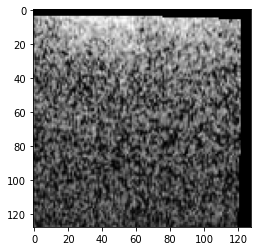

In [ ]:
img, label = image_datasets[train][0]
print(img.shape, label)
plt.imshow(img[0,:,:],'gray')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


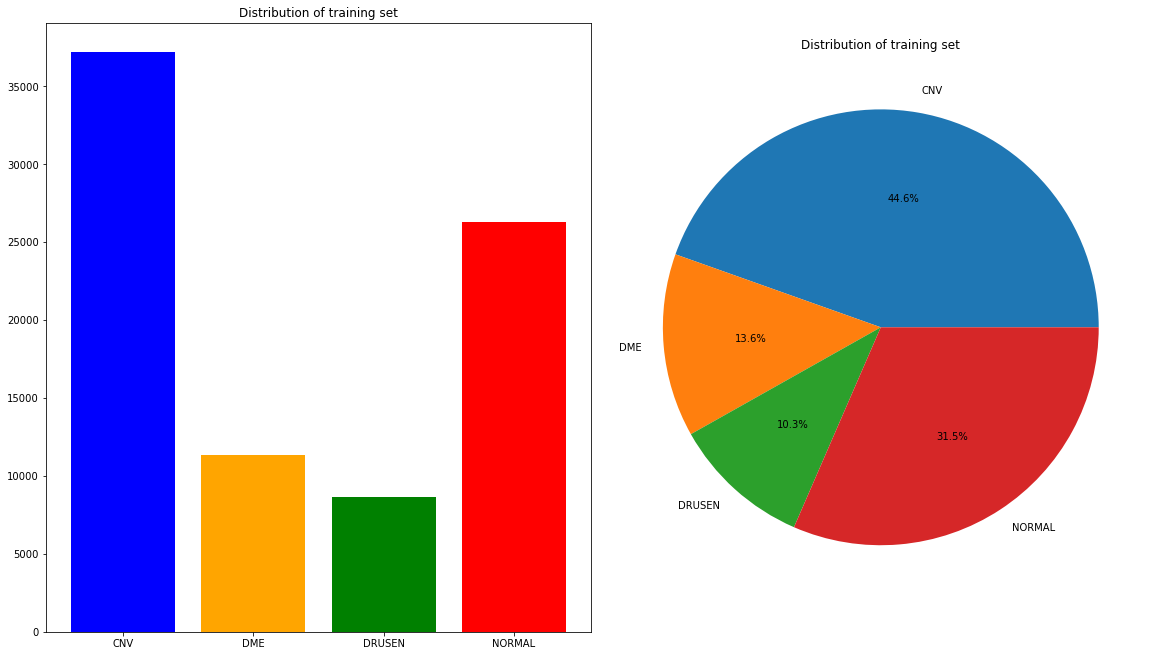

In [ ]:
# classes = image_datasets[train].classes

# classes = image_datasets[train].targets
counter = []
per = []
# image_datasets[train].classes
for i in range(len(image_datasets[train].classes)):
    classes = image_datasets[train].targets
    counter.append(Counter(classes)[i])

for i in range(len(image_datasets[train].classes)):
    per.append(counter[i]/sum(counter))

    
train_weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    per, dataset_sizes[train])
    
%matplotlib inline 
fig = plt.figure(figsize= (16,9),constrained_layout=True)
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, 0])

colors = ['blue', 'orange','green','red']
ax.bar(image_datasets[train].classes, counter, color = colors)
ax.set_title('Distribution of training set');

ax = fig.add_subplot(gs[0, 1])

ax.pie(per,labels = tuple(image_datasets[train].classes),autopct='%1.1f%%')
ax.set_title('Distribution of training set')

plt.show()

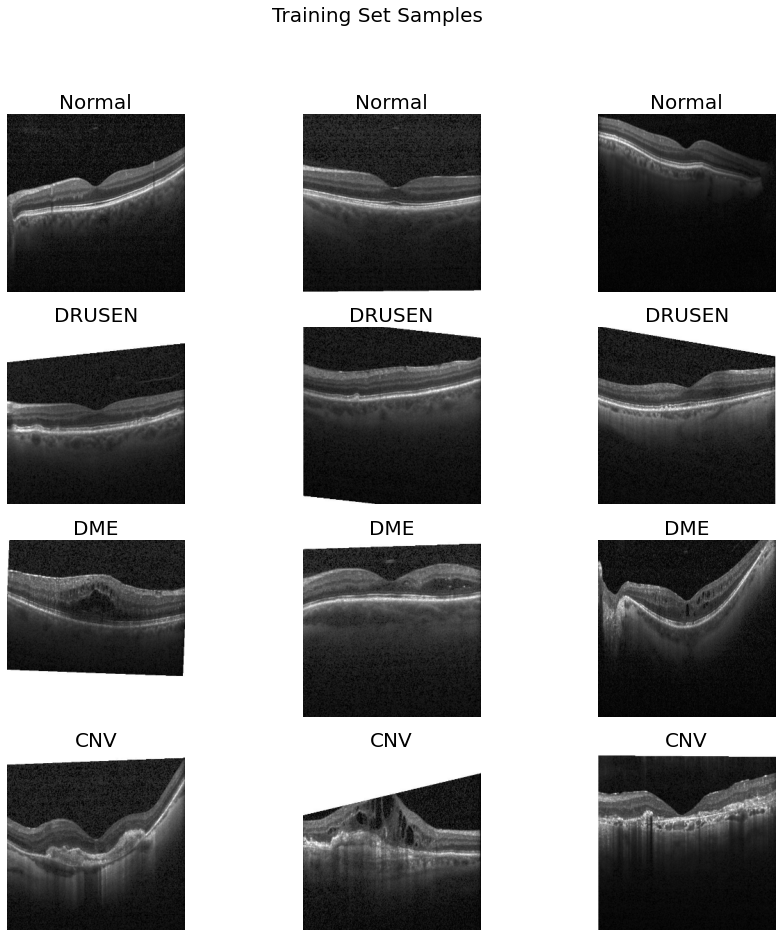

In [ ]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256)) 
        ax[i//3][i%3].imshow(image)
        if i<3:
            ax[i//3][i%3].set_title("Normal", fontsize=20)
        elif 3<= i < 6:
            ax[i//3][i%3].set_title("DRUSEN", fontsize=20)
        elif 6<= i < 9:
            ax[i//3][i%3].set_title("DME", fontsize=20)
        else:
            ax[i//3][i%3].set_title("CNV", fontsize=20)
            
        ax[i//3][i%3].axis('off')
        
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 3) + \
    random.sample([os.path.join(data_dir+'/train/DRUSEN', filename) 
                   for filename in os.listdir(data_dir+'/train/DRUSEN')], 3) + \
    random.sample([os.path.join(data_dir+'/train/DME', filename) 
                   for filename in os.listdir(data_dir+'/train/DME')], 3) + \
    random.sample([os.path.join(data_dir+'/train/CNV', filename) 
                   for filename in os.listdir(data_dir+'/train/CNV')], 3)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=20)
plt.show()

Load data

In [ ]:
train_size = round(len(image_datasets[train])*0.75) # 
temp = len(image_datasets[train]) - train_size # 99%

train_ds,temps = random_split(image_datasets[train], [train_size,temp])


val_size = round(len(temps)*0.02) # 4%
temp = len(temps) - val_size # 99%

val_ds,_ = random_split(temps, [val_size,temp])


len(train_ds),len(val_ds)

(62613, 417)

In [ ]:
train_dl = DataLoader(train_ds, patch_size, num_workers=8, pin_memory=True)
val_dl = DataLoader(val_ds, patch_size, num_workers=8, pin_memory=True)

**define model**


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds


In [ ]:
class OCTresbase(nn.Module):
        # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch,weight):
#     def training_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels,weight=weight)      # weighted compute loss
#         loss = F.cross_entropy(out, labels)      # weighted compute loss

        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
    
        # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}      


In [ ]:
resnet101 = models.resnet101(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
class OCTres(OCTresbase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 4) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader,weight, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):

    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}
    
    
    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch,weight)
#             outputs = model.training_step(batch)

            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       # compute gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients
        
        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 4:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss
            

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(OCTres(), device)

In [ ]:
epochs = 20
lr = 0.0005
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor(per).to(device)

history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl,weight,
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

Epoch [1], train_loss: 0.2917, train_acc: 0.8258, val_loss: 0.3728, val_acc: 0.8833
Epoch [2], train_loss: 0.2348, train_acc: 0.8571, val_loss: 0.3955, val_acc: 0.8603
Epoch [3], train_loss: 0.2147, train_acc: 0.8712, val_loss: 0.3059, val_acc: 0.8855
Epoch [4], train_loss: 0.2070, train_acc: 0.8746, val_loss: 0.3694, val_acc: 0.8567
Epoch [5], train_loss: 0.2019, train_acc: 0.8778, val_loss: 0.2971, val_acc: 0.8948
Epoch [6], train_loss: 0.1984, train_acc: 0.8813, val_loss: 0.3296, val_acc: 0.8684
Epoch [7], train_loss: 0.1893, train_acc: 0.8848, val_loss: 0.3242, val_acc: 0.8784
Epoch [8], train_loss: 0.1894, train_acc: 0.8854, val_loss: 0.2567, val_acc: 0.8989
Epoch [9], train_loss: 0.1862, train_acc: 0.8869, val_loss: 0.3372, val_acc: 0.8857
Epoch [10], train_loss: 0.1819, train_acc: 0.8892, val_loss: 0.3043, val_acc: 0.8933
Epoch [11], train_loss: 0.1787, train_acc: 0.8910, val_loss: 0.3218, val_acc: 0.8625
Epoch [12], train_loss: 0.1795, train_acc: 0.8890, val_loss: 0.4305, val_a

In [ ]:
print('Best loss is:', best_loss)
# Save Model
bestmodel = {'model': OCTres(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, './OCTResnet.pth')

Best loss is: 0.20925819873809814


In [ ]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('./OCTResnet.pth')
# model = to_device(OCTres(), device)

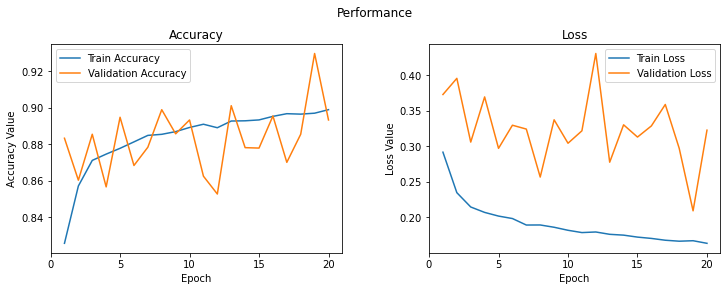

In [ ]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


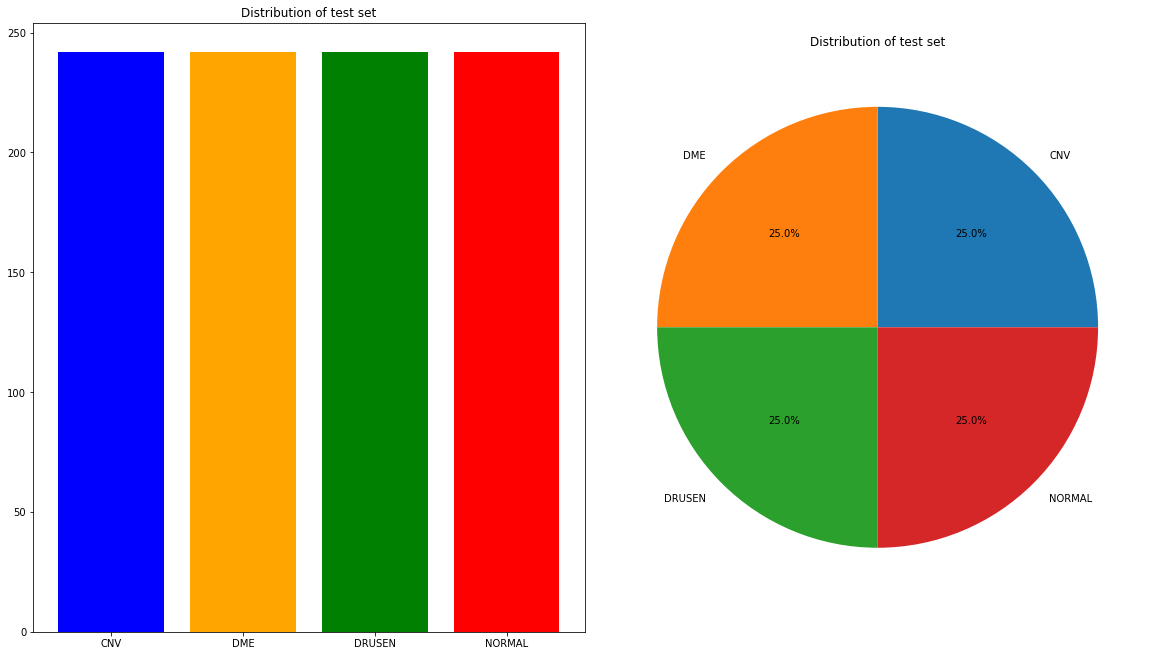

In [ ]:
# classes = image_datasets[train].classes

# classes = image_datasets[train].targets
counter = []
per = []
# image_datasets[train].classes
for i in range(len(image_datasets[test].classes)):
    classes = image_datasets[test].targets
    counter.append(Counter(classes)[i])

for i in range(len(image_datasets[test].classes)):
    per.append(counter[i]/sum(counter))

    
train_weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    per, dataset_sizes[train])
    
%matplotlib inline 
fig = plt.figure(figsize= (16,9),constrained_layout=True)
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, 0])

colors = ['blue', 'orange','green','red']
ax.bar(image_datasets[val].classes, counter, color = colors)
ax.set_title('Distribution of test set');

ax = fig.add_subplot(gs[0, 1])

ax.pie(per,labels = tuple(image_datasets[test].classes),autopct='%1.1f%%')
ax.set_title('Distribution of test set')

plt.show()

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
# len(image_datasets[test])
test_dl = DataLoader(image_datasets[test], patch_size, num_workers=8, pin_memory=True)

test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model.to(device), test_dl)

test_loss: 0.0589, test_acc: 0.9854


<Figure size 432x288 with 0 Axes>

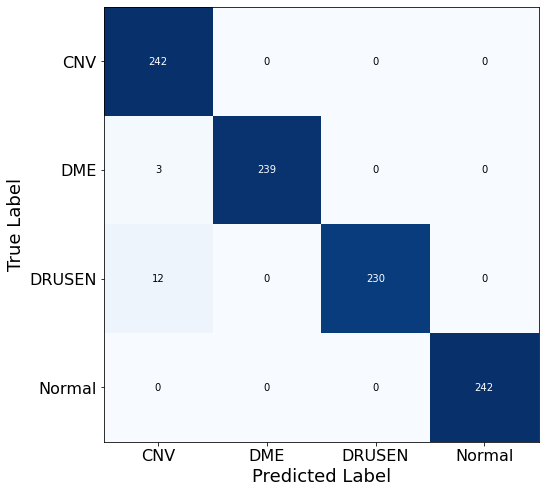

In [ ]:
# # Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(4), ['CNV', 'DME','DRUSEN','Normal'], fontsize=16)
plt.yticks(range(4), ['CNV', 'DME','DRUSEN','Normal'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics

fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)



accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

recall = recall.astype(float)
precision = precision.astype(float)
f1 = f1.astype(float)

print("Accuracy of the model is %.2f"% accuracy)
print('Recall of the model is {}'.format(recall))
print('precision of the model is {}'.format(precision))
print('F1 score of the model is {}'.format(f1))
# print("Precision of the model is %.2f"% precision)
# print("F1 score of the model is %.2f"% f1)

Accuracy of the model is 0.98
Recall of the model is [1.         0.98760331 0.95041322 1.        ]
precision of the model is [0.94163424 1.         1.         1.        ]
F1 score of the model is [0.96993988 0.99376299 0.97457627 1.        ]


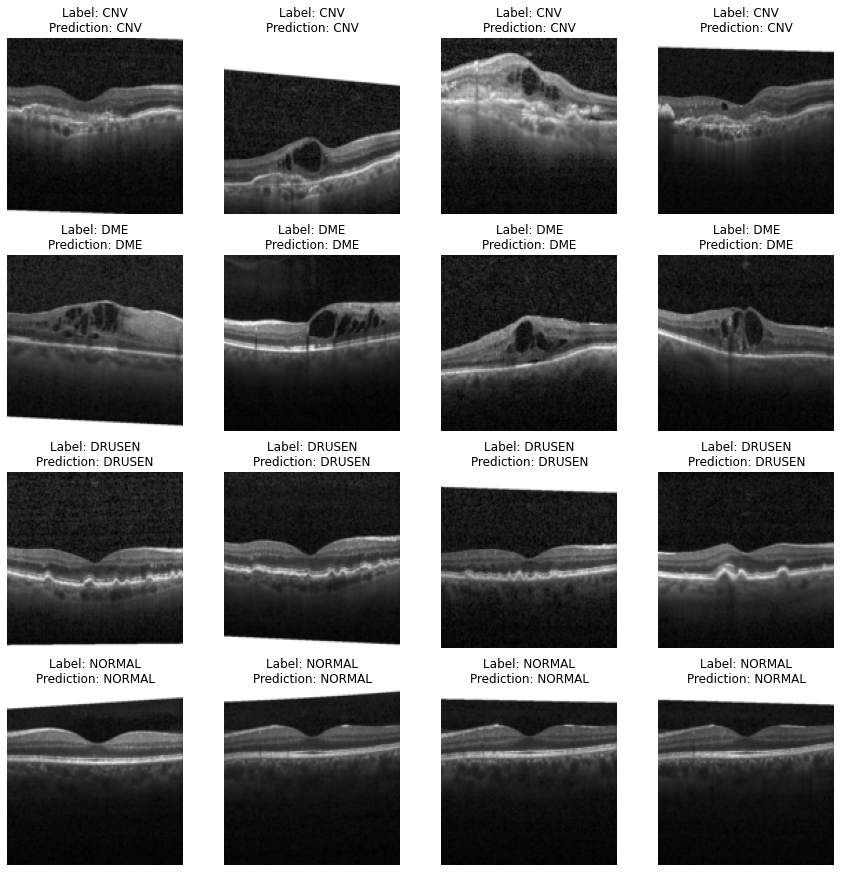

In [ ]:
idxs = torch.tensor(np.append(np.arange(start=0, stop=4, step=1), 
                              np.arange(start=300, stop=304, step=1)))
idxs = torch.tensor(np.append(idxs, 
                              np.arange(start=600, stop=604, step=1)))
idxs = torch.tensor(np.append(idxs, 
                              np.arange(start=900, stop=904, step=1)))

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12,12),constrained_layout=True)

for c,i in enumerate(idxs):
    img_tensor, label = image_datasets[test][i]
    ax[c//4][c%4].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//4][c%4].set_title('Label: {}\nPrediction: {}'
                            .format(image_datasets[test].classes[label], 
                                    image_datasets[test].classes[preds[i]]),
                            fontsize=12)
    ax[c//4][c%4].axis('off')

# for c,i in enumerate(idxs):
#     img_tensor, label = image_datasets[test][i]
#     ax[c//4][c%4].imshow(img_tensor[0,:,:], cmap='gray')
#     ax[c//4][c%4].set_title('Label: {}'.format(image_datasets[test].classes[label]),fontsize=12)

# #     ax[c//4][c%4].axis('off')